In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io, filters
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp')
load_dir = os.path.join(warp_directory,  'data_warp_test.h5')

In [3]:
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def apply_butter_highpass(data, z, cutoff, order, fs):

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    hpf_data = butter_highpass_filter(data[:,:,z, :], cutoff, fs, order)
    return hpf_data

In [4]:
#filter requirements 
order = 2     # ?? wtf is this??
fs = 1.8      # sample rate, Hz
cutoff = 0.01  # desired cutoff frequency of the filter, Hz

In [5]:
%%time
#from warps

with h5py.File(load_dir, 'r') as wf:
        warps = wf['warps'][:]
        dims = np.shape(warps)
        print("Data shape is {}".format(dims))
#         hpf_total = []
#         for z in range(dims[-2]):
#             hpf_data = apply_butter_highpass(warps, z, cutoff, order, fs)
#             hpf_total.append(hpf_data)
#         hpf_total = np.array(hpf_total)
#         hpf_total = np.transpose(hpf_total, (1,2,0,3))
#         dims_hpf = np.shape(hpf_total)
#         print("High Pass Filter Data shape is {}".format(dims_hpf))

Data shape is (314, 146, 91, 3384)
CPU times: user 4.71 s, sys: 22.8 s, total: 27.5 s
Wall time: 19min 59s


In [6]:
# warps = np.rollaxis(warps,0,4)
print(np.shape(warps))

(314, 146, 91, 3384)


In [12]:
warps = warps.astype(np.float16)

In [13]:
np.count_nonzero(warps)

9574947415

In [15]:
warps.dtype

dtype('float16')

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(warps[:,:,20,:],axis=-1).T)

ValueError: Unsupported dtype

<Figure size 720x720 with 1 Axes>

In [7]:
warps = warps[...,:1000]

In [8]:
%%time
hpf_total = []
for z in range(dims[-2]):
    hpf_warps = apply_butter_highpass(warps, z, cutoff, order, fs)
    hpf_total.append(hpf_warps)
hpf_total = np.array(hpf_total)
hpf_total = np.transpose(hpf_total, (1,2,0,3))
dims_hpfw = np.shape(hpf_total)
print("High Pass Filter Data shape is {}".format(dims_hpfw))

High Pass Filter Data shape is (314, 146, 91, 1000)
CPU times: user 1min 6s, sys: 22.4 s, total: 1min 28s
Wall time: 1min 28s


In [9]:
# %%time

# with h5py.File(load_directory, 'r') as hf:
#         data = hf['data'][:] 
#         dims = np.shape(data)
#         print("Data shape is {}".format(dims))
#         hpf_total = []
#         for z in range(dims[-2]):
#             hpf_data = apply_butter_highpass(data, z, cutoff, order, fs)
#             hpf_total.append(hpf_data)
#         hpf_total = np.array(hpf_total)
#         hpf_total = np.transpose(hpf_total, (1,2,0,3))
#         dims_hpf = np.shape(hpf_total)
#         print("High Pass Filter Data shape is {}".format(dims_hpf))

In [10]:
# hpf_total = np.transpose(hpf_total, (1,2,0,3))
print(np.shape(hpf_total))

(314, 146, 91, 1000)


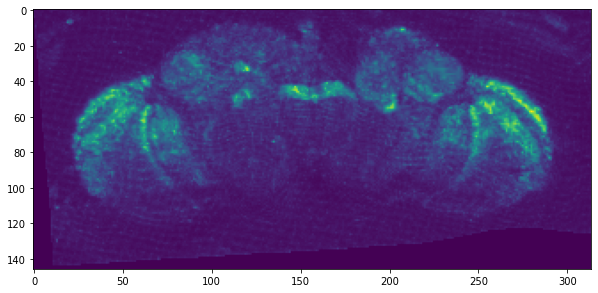

In [12]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(warps[:,:,20,:], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(hpf_total[:,:,20, :], axis=-1).T)

In [13]:
def make_flat_img(x):
    max_proj = np.max(x, axis=2)
    fd = max_proj.shape[1]*max_proj.shape[0]
    flat_img = max_proj.reshape(fd, max_proj.shape[2])
    return np.mean(flat_img, axis=0)

In [14]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd1, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms
loom_ms = [i*10 for i in starts_loom]

loading photodiode data... done


In [15]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [16]:
np.shape(fictrac_timestamps)

(180000,)

In [17]:
np.shape(loom_ms)

(198,)

In [18]:
timestamps = brainsss.load_timestamps(os.path.join(func_path,'func_0', 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [19]:
# #f0 based on the first 5min without the stim
# location = timestamps < loom_ms[0]
# starts_stim_idx = np.min(np.argmax(location == False, axis=0))
# hpf_trunc = hpf_total[:,:,:, 40:starts_stim_idx] #get rid of inital turn on stuff--40 frames seems enough is it too much?
# f0 = np.mean(hpf_trunc, axis=3)
# f0 = np.asarray(f0)
# print(np.shape(f0))
# flaty=make_flat_img(hpf_trunc)
# plt.plot(flaty);

In [20]:
# flaty=make_flat_img(hpf_total)
# plt.plot(flaty);

In [21]:
# %%time
# df=hpf_total/f0[...,None]
# # df = np.array(df)
# # df = np.transpose(df, (1,2,3,0))

In [22]:
# np.shape(df)

In [23]:
# plt.hist(df.flatten(), bins=50);

In [24]:
# np.max(df)

In [25]:
# plt.figure(figsize=(10,10))
# plt.imshow(data[:,:,20,1000].T)
# plt.figure(figsize=(10,10))
# plt.imshow(hpf_total[:,:,20,1000].T)
# plt.figure(figsize=(10,10))
# plt.imshow(f0[:,:,20].T)
# plt.figure(figsize=(10,10))
# plt.imshow(df[:,:,20, 1000].T, vmin=-1000, vmax=3000)

In [26]:
#f0 based on the time before the stim
idx_b4 = []
for i in range(np.shape(loom_ms)[0]):
    bool_array = timestamps < loom_ms[i]
    idx = np.min(np.argmax(~bool_array, axis=0))-1 #might be 1 or 2 frames before the loom--does this difference matter?
    idx_b4.append(idx)
idx_b4 = np.array(idx_b4) # the indicies of the frame before the loom
np.shape(idx_b4)

(198,)

In [27]:
idx_b4

array([ 566,  579,  595,  608,  622,  637,  652,  664,  678,  693,  708,
        722,  737,  751,  765,  779,  791,  804,  819,  832,  846,  861,
        876,  892,  905,  918,  932,  947,  962,  975,  990, 1003, 1016,
       1030, 1045, 1059, 1074, 1089, 1103, 1118, 1132, 1145, 1158, 1172,
       1188, 1202, 1216, 1232, 1245, 1259, 1275, 1290, 1305, 1319, 1334,
       1348, 1362, 1375, 1390, 1403, 1419, 1435, 1451, 1464, 1479, 1492,
       1505, 1521, 1535, 1550, 1563, 1578, 1594, 1607, 1620, 1633, 1648,
       1662, 1675, 1690, 1706, 1719, 1735, 1747, 1762, 1778, 1790, 1806,
       1821, 1836, 1851, 1866, 1878, 1894, 1908, 1924, 1940, 1954, 1968,
       1980, 1994, 2009, 2024, 2037, 2051, 2067, 2081, 2097, 2110, 2124,
       2140, 2156, 2171, 2185, 2198, 2212, 2227, 2241, 2257, 2271, 2286,
       2299, 2314, 2329, 2343, 2357, 2372, 2386, 2402, 2416, 2430, 2444,
       2459, 2472, 2486, 2502, 2514, 2530, 2545, 2561, 2574, 2588, 2603,
       2616, 2630, 2643, 2659, 2671, 2685, 2699, 27

In [62]:
%%time
loom_away = 3 #number of frames away from previous loom
f0_trial = []
for k in range(np.shape(loom_ms)[0]):
    if k>0:
        start = idx_b4[k-1]+loom_away
        end = idx_b4[k]
        if end<=np.shape(warps)[-1]:
            trunc2 = warps[:,:,:,start:end]
            f0 = np.mean(trunc2, axis=3)
            f0_trial.append(f0)
        else:
            break
    else:
        start = idx_b4[k]-10 #kinda random amt of frames before the first loom--maybe change this???
        end = idx_b4[k]
        trunc2 = warps[:,:,:,start:end]
        f0 = np.mean(trunc2, axis=3)
        f0_trial.append(f0)
f0_trial_temp = np.array(f0_trial) #f0 for a few frames before each trial

CPU times: user 12 s, sys: 130 ms, total: 12.1 s
Wall time: 12.1 s


In [63]:
np.shape(f0_trial_temp)

(31, 314, 146, 91)

In [64]:
f0_trial = np.mean(f0_trial_temp, axis=0)
print(np.shape(f0_trial))

(314, 146, 91)


In [65]:
np.count_nonzero(f0_trial)

2836163

In [66]:
np.shape(warps)

(314, 146, 91, 1000)

In [67]:
np.shape(idx_b4)

(198,)

In [68]:
np.max(f0_trial)

8060.0

In [70]:
thresh = filters.threshold_otsu(image=f0_trial)

In [71]:
thresh

1360.0

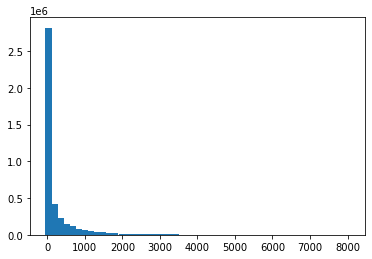

In [72]:
plt.hist(f0_trial.flatten(), bins=50);

In [73]:
mask=f0_trial>thresh

In [74]:
%%time
df_trial = (warps/f0_trial[...,None])
# df_trial = (hpf_total/f0_trial[...,None])
# df_trial = [(hpf_total[:,:,:,i]-f0_trial)/f0_trial for i in range(np.shape(hpf_total)[-1])]
df_trial= np.asarray(df_trial)            

CPU times: user 39.9 s, sys: 1.38 s, total: 41.2 s
Wall time: 41.2 s


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

overflow encountered in true_divide

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [75]:
shape = df_trial.shape
shape_f = [shape[-1], shape[0], shape[1], shape[2]]
print(shape_f)
broadcasted_mask = np.broadcast_to(mask, shape_f)
broadcasted_mask = np.moveaxis(broadcasted_mask, 0, -1)
print(np.shape(broadcasted_mask))

[1000, 314, 146, 91]
(314, 146, 91, 1000)


In [76]:
masked_matrix = np.where(broadcasted_mask, df_trial, 0)

In [77]:
print(np.shape(masked_matrix))

(314, 146, 91, 1000)


In [78]:
np.shape(df_trial)

(314, 146, 91, 1000)

In [79]:
df_trial

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

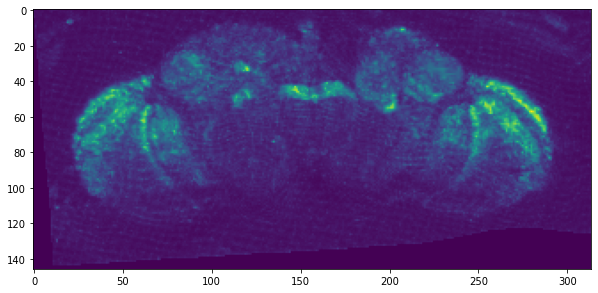

ValueError: Unsupported dtype

<Figure size 720x720 with 1 Axes>

In [80]:
# plt.figure(figsize=(10,10))
# plt.imshow(data[:,:,20,1000].T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(hpf_total[:,:,20, :],axis=-1).T)
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(warps[:,:,20,:], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(f0_trial[:,:,20].T)
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(df_trial[:,:,20,:],axis=-1).T)
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(masked_matrix[:,:,20,:],axis=-1).T)